# PageRank a pequeña escala
## Un algoritmo para clasificar páginas web

 - Programado por **Nicolás Quijada**

En este notebook realizamos una implementación del algoritmo PageRank a pequeña escala. 
Dividimos el documento en 6 secciones: en la primera definimos la matriz de google y definimos una función para obtenerla. En la segunda damos una función para correr el algoritmo sobre una red construida de manera aleatoria. En la tercera sección utilizamos la base de datos del _cora dataset_ (https://graphsandnetworks.com/the-cora-dataset/) para hacer un ranking de los papers organizados en ella. La visualizamos y ejecutamos el algoritmo. En el resto de las secciones analizamos los resultados obtenidos y concluímos.  

Este notebook fue elaborado para la materia de _Procesos Estocásticos_ en el semestre 2024-1 de la Facultad de Ciencias de la UNAM (México). 



## 1. La _matriz de Google_

Consideremos una gráfica dirigida (de ahora en adelante llamada __red__) con $N\gt 0$ nodos (que llamaremos __páginas__). A partir de ella construímos su matriz de adyacencia $A$ donde $(A)_{ij} = 1$ si la página $B_i$ accede a la página $B_j$ y $(A)_{ij} = 0$ en otro caso. Además tomemos $\alpha \in [0,1]$ constante. Construimos la matriz $A'$ a partir de $A$ como sigue:

Para cada $i \in {1,\dots,N}$ consideramos la fila $A_i$. Si todas las entradas de la fila son $0$ rellenamos la fila con el número $\frac{1}{N}$. En otro caso, consideramos $|B_i|$ el número de unos de la fila y hacemos cada entrada de la fila $\frac{1}{|B_i|}$. Al resultado estas operaciones le llamamos $A'$.

Llamando $\mathbb{1}_{N}$ a la matriz de dimensión $N\times N$ con cada entrada igual a $1$ definimos la matriz de google $G$ como 

$$
G := (1-\alpha)A' + \frac{\alpha}{N} \mathbb{1}_{N} 
$$

A continuación programamos el algoritmo para la construcción de la matriz.


In [115]:
#Importación de bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import csv
import networkx as nx
import matplotlib.pyplot as plt
from colour import Color



In [5]:
#Algoritmo para obtener la matriz de Google. En este caso la constante "d" es el nombre dado a "alfa".

def matgo(A, d = 0.15):
    '''
    La función recibe 2 argumentos: 
    A es la matriz de adyacencia de la red (i.e., una matriz cuadrada de NxN. Cada entrada debe ser o bien 0 o bien 1)
    d es el factor de amortiguamiento considerado para el cálculo del PageRank
    
    Regresa P, una matriz estocástica de la misma dimensión que la matriz A obtenida según el algoritmo presentado
    '''
    N = A.shape[0] #Encuentra la dimensión de la matriz. Usa la primera entrada dado que es cuadrada
    P = np.zeros((N,N)) #Matriz de 0 de dimensión NxN que será rellenada con base en el algoritmo
    for i in range(A.shape[0]): #Para cada fila de la matriz de adyacencia
        k = list(A[i,:]).count(1) #Contamos el número de números 1 en la fila
        if k > 0: #Si tenemos más de un número 1
            P[i, :] = A[i,:]/k #Dividimos la fila por la cantidad de 1's en ella
        else: #Si no tenemos unos
            P[i, :] = 1/N #Cada entrada de la fila se define como 1/N
    
    Q = d/N * np.ones((N,N)) #Se da una matriz donde cada entrada es d/N
    P = (1-d)*P + Q #Definimos la matriz de transición como la suma de la matriz P preliminar más la matriz Q
    return P #Se regresa la matriz de transición

## 2. Una red de prueba

En el resto del notebook trabajaremos con una matriz particular. Sin embargo, en este bloque programamos una función que regresa una matriz de adyacencia a partir de su tamaño. Esta es generada de manera aleatoria usando la biblioteca _random_ y puede ser usada para probar el código a menor escala.

In [7]:
def rbm(N):
    '''
    Función que recibe un entero positivo.
    
    Regresa una matriz de tamaño NxN cuyas entradas son 0 o 1 de manera aleatoria
    '''
    
    # Matriz de ceros
    matrix = np.zeros((N, N), dtype=int)

    # Rellenamos la matriz con ceros y unos
    matrix[np.random.randint(2, size=(N, N)).astype(bool)] = 1

    return np.array(matrix)

# Tamaño de la matriz
N = 10

# Generamos la matriz
ex = rbm(N)

# Imprimimos
print(ex)

[[0 0 1 0 1 0 1 1 1 0]
 [0 1 1 1 1 0 1 0 1 0]
 [0 1 1 0 1 1 1 0 1 0]
 [0 1 1 1 0 0 0 0 0 1]
 [0 1 0 1 0 0 1 0 0 1]
 [1 1 1 0 1 1 0 0 1 0]
 [0 0 1 0 1 0 1 1 0 0]
 [1 0 1 0 1 0 1 0 1 0]
 [1 0 0 0 0 1 0 1 0 0]
 [1 0 0 1 1 0 1 1 0 0]]


## 3. Implementación con una base de datos real

Consideramos la base de datos _The Cora Dataset_ que contiene _2708_ nodos (_papers_) y los _5429_ links entre ellos. Esta fue recuperada desde https://graphsandnetworks.com/the-cora-dataset/. 

In [111]:
#Carga de datos
aristas = [] #Diccionario para guardar las aristas entre los vértices

with open('edges.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Los nombres de las columnas son: {", ".join(row)}')
            line_count += 1
        else:
            aristas.append((int(row[1]),int(row[2])))
            
            line_count += 1
    print(f'Se procesaron {line_count} líneas.')

Los nombres de las columnas son: , sourceNodeId, targetNodeId, relationshipType
Se procesaron 10557 líneas.


Usamos Networkx para obtener nuestra red

In [127]:
red = nx.DiGraph() #Objeto red
red.add_edges_from(aristas) #Se añaden las aristas de la base de datos
nodos = red.nodes
grados = nx.degree(red)
incidencias = [par[1] for par in list(grados)]

### 3. 1 Visualización

En este bloque visualizamos nuestra red utilizando la paquetería networkx. Modificamos el tamaño de los nodos con base en la cantidad de aristas que inciden en ellos. 

In [182]:
#Gradiente de color
colors = list(Color("red").range_to(Color("blue"), 157)) #Creamos un gradiente de color

In [215]:
#Configuración de aristas, colores y tamaños
cls = ["#800000"] + [str(colors[i[1]]) for i in list(grados)[1:]] #Coloreamos cada nodo con base en su grado
tms = [i[1]*2 for i in nx.degree(red)] #Damos el tamaño de cada nodo con base en su grado
tms[0] = max(tms[1:]) + 30 #Ajustamos el tamaño del nodo más grande
lineas = [red.degree(tupla[0])/20 for tupla in red.edges()] #Ajustamos el tamaño de las líneas

In [216]:
#Etiquetado de los nodos principales
etiquetas = {}
for par in red.degree:
    if par[1] > 50:
        etiquetas[par[0]] = par[1]

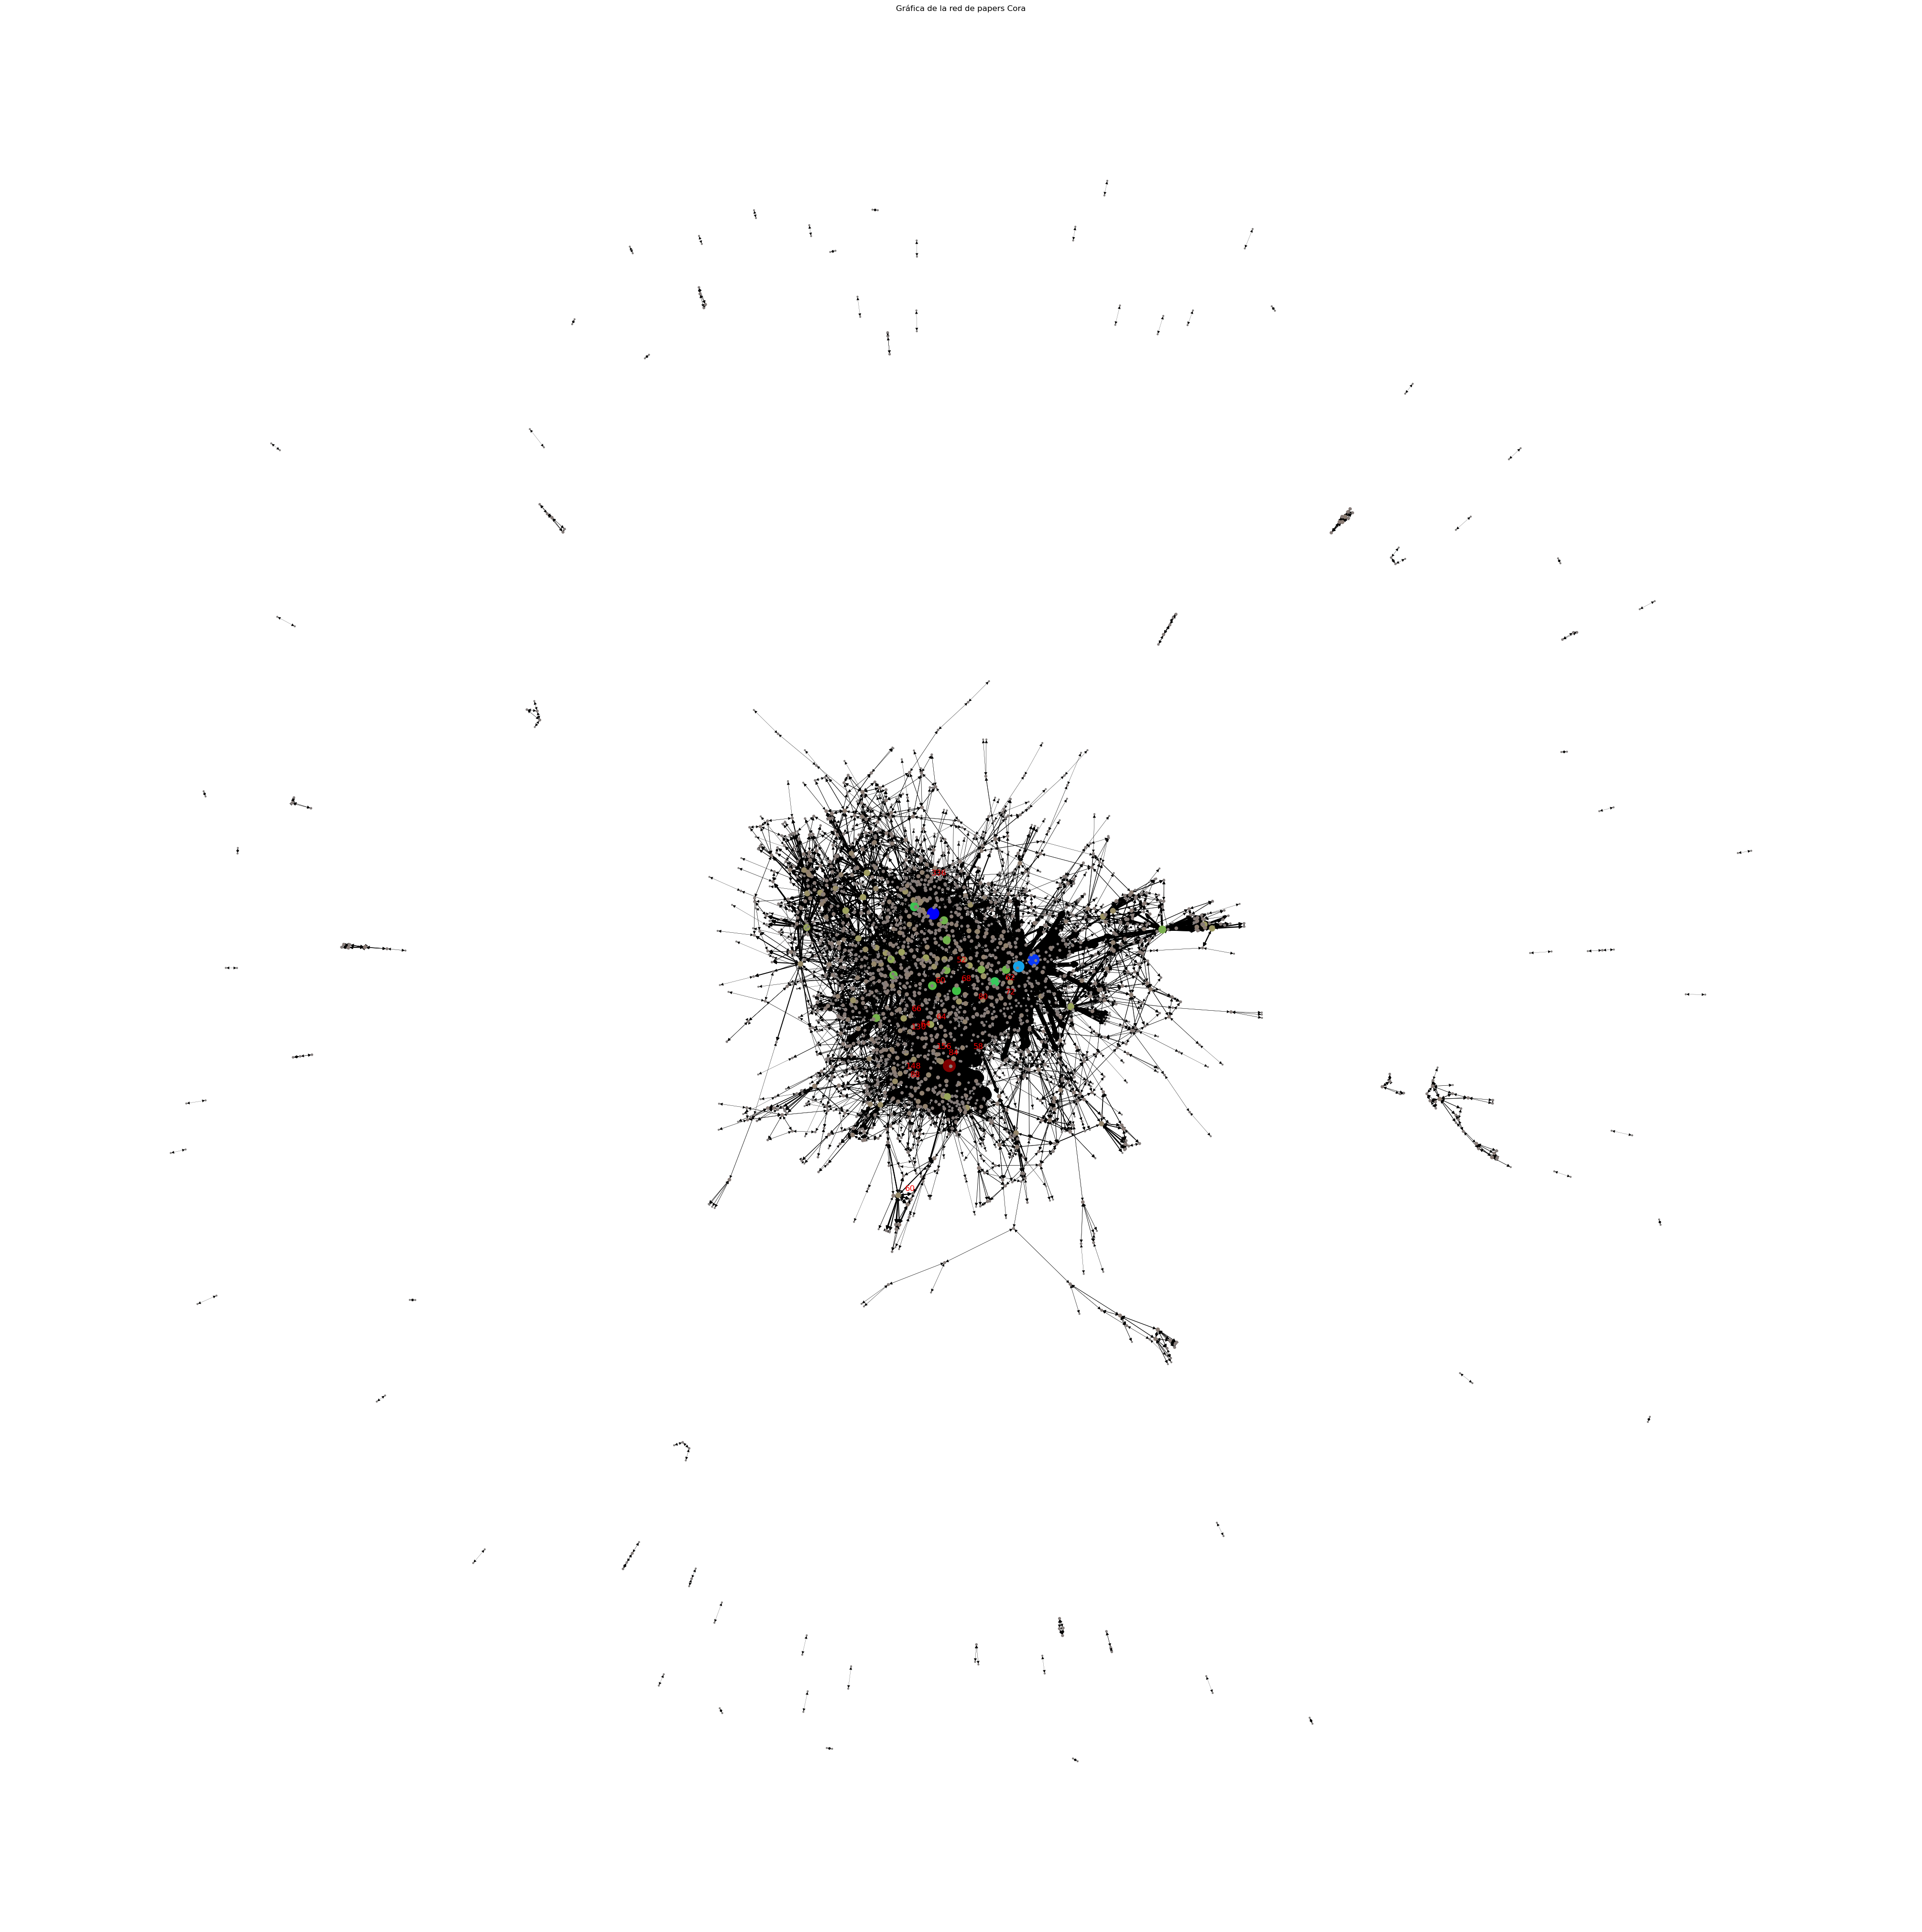

In [218]:
#Gráfica de la figura
fig = plt.figure(figsize=(40, 40)) 
nx.draw(red, pos = nx.spring_layout(red), with_labels = False, node_size = tms,node_color = cls, font_color = "w", font_size = 9, width = lineas)
nx.draw_networkx_labels(redd, pos = nx.spring_layout(red), labels = etiquetas, font_color = 'r')
plt.title("Gráfica de la red de papers Cora")
plt.show()
fig.savefig('red_visual.svg') 

### 3. 2 Obtención de la matriz de Google para la red Cora

En este bloque preparamos nuestros datos para obtener la matriz de google con la función programada al inicio

In [17]:
#Preparación de los datos

dim = 2708 #Cantidad de nodos
M = np.zeros((dim, dim)) #Matriz de ceros con la cantidad de nodos de la red
vers = list(red.nodes()) #Vértices de la matriz
ars = list(red.edges()) #Aristas entre los nodos

In [27]:
# Matriz de adyacencia
#La idea, en vez de iterar sobre la matriz, es iterar sobre las aristas provistas, recuperar los índices de los papers
#a partir de sus id's y rellenar esas entradas de la matriz

for par in range(len(ars)):
    i = vers.index(ars[par][1])
    j = vers.index(ars[par][0])
    M[i,j] = 1

In [29]:
# Matriz de adyacencia
print(M)

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [33]:
# Matriz de google
G = matgo(M)

### 3.3 Distribución estacionaria

Obtenemos la matriz de Google de nuestra matriz de adyacencia. Para ello multiplicamos sucesivamente la matriz de google (que resulta ser estocástica y con una única distribución estacionaria) para obtener el pagerank de las páginas.

In [219]:
#Definición de variables para el algoritmo
transition_matrix = G
disi = np.ones((1,dim))/dim

In [76]:
#Consideramos la siguiente matriz de transición entre nuestros estados:

#Damos una distribución inicial. Con ella buscaremos encontrar la distribución estacionaria.
initial_distribution = disi

# Listas para guardar la evolución de la distribución y la iteración
distributions = [initial_distribution]
iterations = 50

# Multiplicamos distribución por matriz de transición y repetimenos el proceso "iterations" veces
for i in range(iterations):
    new_distribution = np.dot(distributions[-1], transition_matrix)
    distributions.append(new_distribution)

# Convertir a un array de NumPy para facilitar el acceso
distributions = np.array(distributions)

Visualizamos las distribuciones de probabilidad obtenidas con las iteraciones.

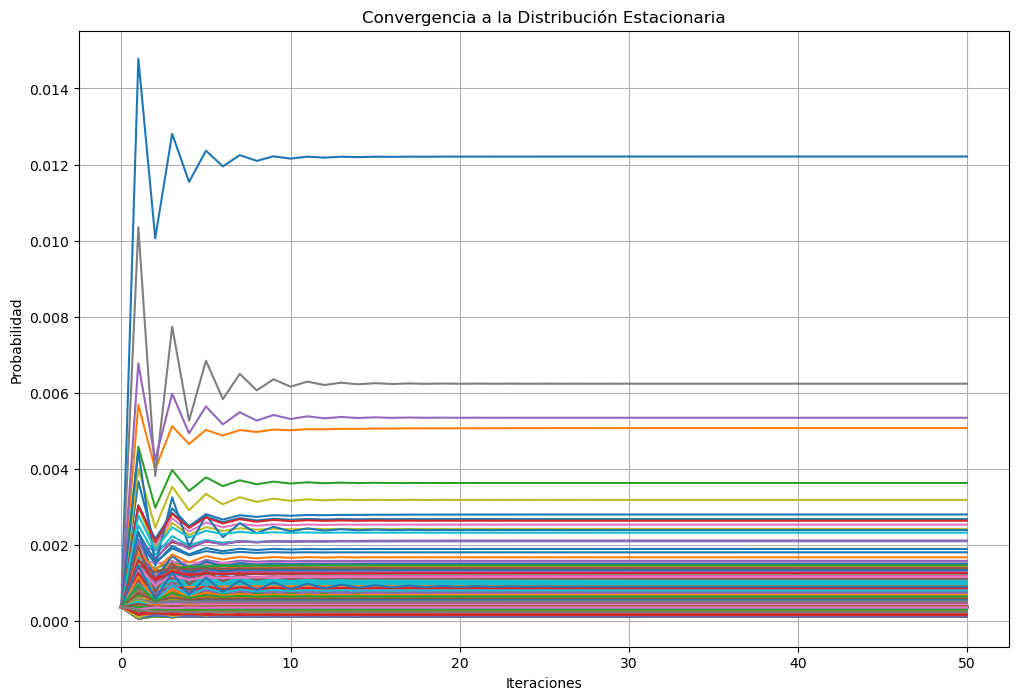

In [77]:
# Visualizamos
plt.figure(figsize=(12, 8))

#Para las 50+1 simulaciones, graficamos la distribución de cada una de las entradas de la distribución.
for i in range(dim):
    plt.plot(range(iterations + 1), distributions[:, :, i], label=f"Estado {i+1}")

plt.title("Convergencia a la Distribución Estacionaria")
plt.xlabel("Iteraciones")
plt.ylabel("Probabilidad")
#plt.legend()
plt.grid(True)
plt.show()

La última distribución es la que consideraremos el PageRank de las páginas:

In [80]:
pr = list(distributions[-1][0]) #Pagerank de las páginasb

A continuación damos una lista con el ranking de las páginas y PageRank

In [90]:
ranking = [(pr.index(ran), ran) for ran in sorted(pr,reverse = True)]

## 4. Análisis de resultados

En esta sección analizamos los resultados obtenidos

In [221]:
#Primeras 20 páginas

print("Número del paper / PageRank")
for i in range(30):
    print(ranking[i])

Número del paper / PageRank
(0, 0.012210525467713618)
(377, 0.006237199453017153)
(714, 0.005341412719555459)
(261, 0.005069675435369967)
(272, 0.0036257891297748336)
(818, 0.003181581227306195)
(170, 0.00279835834219644)
(760, 0.002676303564310221)
(1493, 0.0026340292315088195)
(346, 0.0025322230481565015)
(528, 0.0024151789435256756)
(1240, 0.002388647197693729)
(1599, 0.0023193450923808968)
(854, 0.0021073959144692965)
(223, 0.0021072784717035623)
(599, 0.0020995415818670397)
(164, 0.002094325889215452)
(1120, 0.0018914065555275426)
(880, 0.0018034929072421177)
(2101, 0.0016727385040773413)
(1194, 0.0015782218281598758)
(1206, 0.0015143351612395873)
(1230, 0.001503261137314992)
(872, 0.0014902511658168157)
(1130, 0.0014691204328423032)
(1302, 0.001463086818859193)
(551, 0.0014052981974390316)
(446, 0.0014049986416890786)
(52, 0.0013991748946299801)
(1835, 0.0013862739548833962)


### 4. 1 Comparación con otras formas de clasificación

Un método _naive_ para clasificar las páginas sería el siguiente: dada una página, su ranking es el número de páginas que acceden a ella. Encontrémoslo.

In [114]:
#print(vers)
orden = sorted(list(red.degree()), key = lambda x: x[1], reverse = True)
naive = [(list(red.nodes()).index(par[0]), par[1]) for par in orden]

print("Número del paper / Páginas que conectan a él")
for i in range(30):
    print(naive[i])

Número del paper / Páginas que conectan a él
(0, 336)
(261, 156)
(377, 148)
(714, 130)
(272, 88)
(170, 84)
(818, 80)
(760, 72)
(346, 68)
(1493, 66)
(223, 64)
(854, 64)
(528, 62)
(164, 60)
(599, 60)
(1599, 58)
(1120, 52)
(880, 46)
(1240, 46)
(2101, 46)
(52, 44)
(1130, 42)
(1194, 42)
(1302, 42)
(579, 38)
(872, 38)
(1206, 38)
(1230, 38)
(1835, 38)
(551, 36)


Vemos que hay una diferencia entre la clasificación de las páginas hechas con PageRank y las obtenidas a partir del número de incidencias. Si bien el primer lugar de ambas clasificaciones es el mismo (paper número 0), el segundo lugar es del paper 377 que en el caso del rankeo _naive_ baja al tercer lugar. Es decir, desde un inicio vemos que el que más vértices apunten a una página dada no implica necesariamente que esa página tenga un ranking superior a otras. 

Hay una inversión de ranking entre las páginas 170 y 818; con PR la primera queda por abajo y con la segunda clasificación queda por arriba. No obstante, en general hay una tendencia a mantener el orden decreciente proporcionado por el ranking del número de páginas intercalando otras. 

### 4.2 Sobre PageRank

De acuerdo con la gráfica _Convergencia a la distribución estacionaria_ a partir de la iteración $50$ se aprecia una convergencia a la distribución estacionaria. De hecho, a partir de la décima iteración el comportamiento comienza a estabilizarse. En cuanto a las páginas con un menor número de nodos hay un retraso en la convergencia llegando incluso a las iteración $20$ que, de nuevo, se ve amortigüado con el avance de las iteraciones.

En términos de memoria la matriz de incidencia de la red tiene ~ $3000^{2}$ entradas. De ello resulta más práctico el llenado directo de las entradas con base en la base de datos de las aristas en comparación a la iteración por las entradas de la matriz. Es decir que, en caso de contar con una matriz más grande, puede resultar más eficiente (computacionalmente y en términos de memoria) trabajar directamente con los datos de adyacencia. Más aún, en caso de contar con una base de datos mayor puede recurrirse al uso de una matriz dispersa (sparse matrix) para ahorrar recursos. 

## 5. Conclusiones

A partir de la matriz de google construída con la matriz de adyacencia de una red es posible encontrar una única distribución estacionaria cuyas entradas son interpretadas como el PageRank de la página. Más aún, las instrucciones requeridas para implementar la matriz de Google y con ella llevar a cabo el cálculo de la clasificación son programables con herramientas no especializadas. 

El sistema, tal como plantea el _paper_ original resulta escalable. No obstante, se pueden presentar otros métodos para resolver la ecuación $\Pi_{0} = \Pi_{0}G$ que resulten no solo exactos sino que prescindan de la necesidad de iterar una multiplicación de matrices. 

## 6. Más información

Para más información sobre la base de datos es posible consultar la página original: https://paperswithcode.com/dataset/cora

En cuanto al algoritmo referimos el paper original de Larry y Sergey: http://infolab.stanford.edu/~backrub/google.html y la patente del sistema: https://patents.google.com/patent/US6285999B1/en